In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 2.1 MB/s  0:00:17 eta 0:00:010:00:01


In [1]:
# prompt: import essential packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
#import torch
from sklearn.preprocessing import StandardScaler, LabelEncoder # Atau OneHotEncoder
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem # Untuk MACCS Keys

print("Packages imported successfully.")


2025-10-15 11:21:41.373456: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-15 11:21:41.969897: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-15 11:21:44.207605: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Packages imported successfully.


# Import Data

In [9]:
# Baca CSV tanpa header
df = pd.read_csv("https://raw.githubusercontent.com/adistyadito/LSTM-MBA/refs/heads/main/GSARPC3.csv")

# Tampilkan beberapa baris pertama
df

# Check for missing values
print(f'Data kosong = {df.isnull().sum()}')

Data kosong = cid           0
smiles        0
acvalue       0
categories    0
dtype: int64


In [3]:
df = pd.read_csv('/home/dito-adistya/Dito/TA/Coding/LSTM-MBA/data/outputFingerprint.csv')
df

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,44244736,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,44244911,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,44245235,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10451021,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,44245073,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,145958114,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
632,145950639,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
633,3168508,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
634,145952863,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Preprocess**

In [10]:
from rdkit import Chem
from rdkit.Chem import AllChem # Tetep perlu buat beberapa hal di RDKit
from rdkit.Chem import rdFingerprintGenerator # Import generator
smiles_clean = df['smiles'].tolist()

mols = []
for smiles in smiles_clean:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mols.append(mol)
    else:
        print(f"Warning: Could not create mol object for SMILES: {smiles}")
        pass # Skip adding None

# --- Langkah 4: Generate Fingerprint dari List Objek Molekul (mols) ---
# Parameter fingerprint
radius = 2
nBits = 1024 # Ukuran vektor fingerprint

# Bikin generatornya
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=nBits)

fingerprints = []
# Sekarang lu iterasi di list 'mols' yang isinya objek molekul
for mol in mols:
    # Cek lagi kalau-kalau ada None di list mols (meskipun seharusnya nggak ada kalau langkah 3 bener)
    if mol is not None:
        # Panggil generator untuk bikin fingerprint
        fp = fpgen.GetFingerprint(mol)
        # Ubah BitVector ke numpy array
        fingerprints.append(np.array(fp))
    else:
        # Handle kalau ada None di mols (misalnya append vektor nol)
        fingerprints.append(np.zeros(nBits))

# Konversi list fingerprints jadi NumPy array besar (Ini X lu)
X = np.array(fingerprints)

# --- Langkah 5: Siapkan Data Target (y) ---
# Pastiin nama kolom target lu bener
df['label'] = df['categories'].map({'inhibitor': 1, 'neutral': 0})
y = df['label'].values

# --- Langkah 6: Split Data (Train/Test/Validation) ---
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# prompt: print df yang asli dengan dataset yang diproses dari mols from smiles dan yang sudah diproses dengan fingerprint

print("\nDataFrame Original:")
print(df.head())

print("\nList of RDKit Mol Objects (first 5):")
# Print first 5 mol objects to show they were created
for i, mol in enumerate(mols[:5]):
    if mol:
        print(f"Mol object {i+1}: {mol.GetNumAtoms()} atoms")
    else:
         print(f"Mol object {i+1}: None")

print("\nNumPy Array of Fingerprints (X - shape):")
print(X.shape)
print("\nNumPy Array of Fingerprints (X - first row):")
print(X[0][:20]) # Print first 20 bits of the first fingerprint



DataFrame Original:
        cid                                             smiles  acvalue  \
0  44244736  COC1=C(C(=C(C=C1)C2=C(OC(=N2)C3=CC=CC=C3F)SC4=...   0.0030   
1  44244911  CC1=NN=C(S1)SC2=C(N=C(O2)C3=CC=CC=C3F)C4=C(C(=...   0.0035   
2  44245235  COC1=C(C(=C(C=C1)C2=C(OC(=N2)C3=CN=CC=C3)SC4=N...   0.0047   
3  10451021  CC(=CC1=CC(=C(C=C1)OC)O)C(=O)C2=CC(=C(C(=C2)OC...   0.0090   
4  44245073  CC1=CN=C(N=C1C)SC2=C(N=C(O2)C3=CC=CC=C3Cl)C4=C...   0.0180   

  categories  label  
0  inhibitor      1  
1  inhibitor      1  
2  inhibitor      1  
3  inhibitor      1  
4  inhibitor      1  

List of RDKit Mol Objects (first 5):
Mol object 1: 34 atoms
Mol object 2: 31 atoms
Mol object 3: 30 atoms
Mol object 4: 26 atoms
Mol object 5: 33 atoms

NumPy Array of Fingerprints (X - shape):
(636, 1024)

NumPy Array of Fingerprints (X - first row):
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]


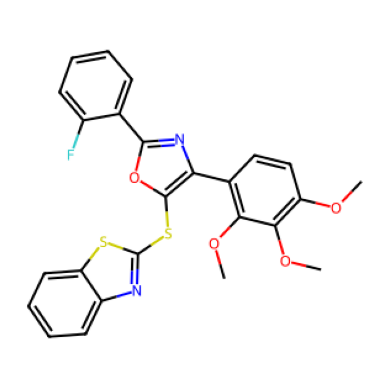

In [6]:
# prompt: coba draw salah satu smiles

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

# Pilih salah satu objek molekul dari list `mols`
# Misalnya, kita ambil molekul pertama
mol_to_draw = mols[0]

# Jika mol_to_draw bukan None, maka gambar
if mol_to_draw is not None:
  # Gambar molekul
  img = Draw.MolToImage(mol_to_draw)

  # Tampilkan gambar
  plt.imshow(img)
  plt.axis('off') # Matikan sumbu
  plt.show()
else:
  print("Objek molekul pertama tidak valid.")

# Anda juga bisa mencoba menggambar molekul lain, misalnya molekul ke-50:
# mol_to_draw_50 = mols[49] # Indeks dimulai dari 0
# if mol_to_draw_50 is not None:
#   img_50 = Draw.MolToImage(mol_to_draw_50)
#   plt.imshow(img_50)
#   plt.axis('off')
#   plt.show()
# else:
#    print("Objek molekul ke-50 tidak valid.")

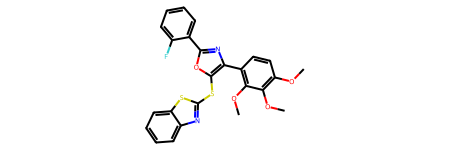

In [ ]:
mll

In [7]:
df

,cid,smiles,acvalue,categories,label
0,44244736,COC1=C(C(=C(C=C1)C2=C(OC(=N2)C3=CC=CC=C3F)SC4=...,0.0030,inhibitor,1
1,44244911,CC1=NN=C(S1)SC2=C(N=C(O2)C3=CC=CC=C3F)C4=C(C(=...,0.0035,inhibitor,1
2,44245235,COC1=C(C(=C(C=C1)C2=C(OC(=N2)C3=CN=CC=C3)SC4=N...,0.0047,inhibitor,1
3,10451021,CC(=CC1=CC(=C(C=C1)OC)O)C(=O)C2=CC(=C(C(=C2)OC...,0.0090,inhibitor,1
4,44245073,CC1=CN=C(N=C1C)SC2=C(N=C(O2)C3=CC=CC=C3Cl)C4=C...,0.0180,inhibitor,1
...,...,...,...,...,...
631,145958114,COC1=CC=C(C=C1)C(=O)C=CC2=CC=C(C=C2)N3C=C(N=N3...,100.0000,neutral,0
632,145950639,C1=CC=C(C=C1)C2=C(N=NC(=N2)SCC3=CN(N=N3)CC4=CC...,100.0000,neutral,0
633,3168508,C1=CC=C(C=C1)C2=C(N=NC(=N2)SCCC(=O)O)C3=CC=CC=C3,100.0000,neutral,0
634,145952863,CC(C)CC(C(=O)NO)NC(=O)NCC1=CN(N=N1)CC2=CC=CC=C...,119.1000,neutral,0


In [8]:
df_fingerprints

NameError: name 'df_fingerprints' is not defined

In [12]:
import numpy as np
# Anggap X_train, X_test, y_train, y_test udah ada dari hasil train_test_split lu di atas

# --- Statistik Data Train ---
train_size = X_train.shape[0]
# Hitung jumlah Label 0 di y_train
train_label_0_count = np.sum(y_train == 0)
# Hitung jumlah Label 1 di y_train
train_label_1_count = np.sum(y_train == 1) # Atau train_size - train_label_0_count

print("--- Train Data ---")
print(f"Total samples: {train_size}")
print(f"Label 0: {train_label_0_count}")
print(f"Label 1: {train_label_1_count}")
print("-" * 18) # Garis pemisah

# --- Statistik Data Test ---
test_size = X_test.shape[0]
# Hitung jumlah Label 0 di y_test
test_label_0_count = np.sum(y_test == 0)
# Hitung jumlah Label 1 di y_test
test_label_1_count = np.sum(y_test == 1) # Atau test_size - test_label_0_count

print("--- Test Data ---")
print(f"Total samples: {test_size}")
print(f"Label 0: {test_label_0_count}")
print(f"Label 1: {test_label_1_count}")
print("-" * 17) # Garis pemisah

# Kalau lu mau lihat statistik data ASLI (sebelum split)
# Asumsi X dan y adalah data lu sebelum displit
# total_dataset_size = X.shape[0]
# total_label_0_count = np.sum(y == 0)
# total_label_1_count = np.sum(y == 1)
# print("\n--- Original Dataset ---")
# print(f"Total samples: {total_dataset_size}")
# print(f"Label 0: {total_label_0_count}")
# print(f"Label 1: {total_label_1_count}")
# print("-" * 24)

--- Train Data ---
Total samples: 508
Label 0: 261
Label 1: 247
------------------
--- Test Data ---
Total samples: 128
Label 0: 60
Label 1: 68
-----------------


**Split Data**

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Modelling

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam

| Baseline   | Layer | Units       | Act  | LR    | Rec. Act | Dropout |
|------------|-------|-------------|------|-------|----------|---------|
| Baseline 1 | 1     | [128]       | tanh | 0.001 | sigmoid  | 0.2     |
| Baseline 2 | 2     | [128,64]    | tanh | 0.001 | sigmoid  | 0.3     |
| Baseline 3 | 3     | [128,64,32] | tanh | 0.001 | sigmoid  | 0.4     |

## Baseline 1

| Baseline   | Layer | Units       | Act  | LR    | Rec. Act | Dropout |
|------------|-------|-------------|------|-------|----------|---------|
| Baseline 1 | 1     | [128]       | tanh | 0.001 | sigmoid  | 0.2     |

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Reshape # Tambah Reshape
from tensorflow.keras.optimizers import Adam
tf.random.set_seed(42)

# Assume nBits is the size of your fingerprint (e.g., 1024)
nBits = 1024 # Sesuaikan dengan nBits yang lu pake di RDKit

units = [32] # Ukuran hidden state LSTM
dropout_rate = 0.2
learning_rate = 0.001

# Build the model for Fingerprint input
model_baseline_1 = Sequential()

# Layer Input: Langsung terima vektor fingerprint
# Bentuk inputnya adalah (panjang_fingerprint,)
model_baseline_1.add(tf.keras.Input(shape=(nBits,))) # Define input shape

# Tambahkan layer Reshape untuk mengubah (nBits,) menjadi (1, nBits)
# Agar cocok dengan input shape LSTM yang butuh 3D (samples, timesteps, features)
model_baseline_1.add(Reshape((1, nBits))) # Ubah (features,) jadi (1, features)

# Layer LSTM: Sekarang inputnya udah 3D (samples, 1, nBits)
# Return sequences False karena kita cuma punya 1 timestep dan mau output single vector
model_baseline_1.add(LSTM(units[0], activation='tanh', recurrent_activation='sigmoid', return_sequences=False))

# Layer Dropout
model_baseline_1.add(Dropout(dropout_rate))


model_baseline_1.add(Dense(1, activation='sigmoid')) # Ganti kalau task-nya regresi

# Compile the model
model_baseline_1.compile(optimizer=Adam(learning_rate=learning_rate),
                        loss='binary_crossentropy',
                        metrics=['accuracy', 'AUC'])

model_baseline_1.summary() # Penting buat ngecek arsitektur dan shape

# Train the model
history_baseline_1 = model_baseline_1.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32
)

# Evaluate the model
loss, accuracy, auc = model_baseline_1.evaluate(X_test, y_test)
print(f"Baseline 1 Test Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_6 (Reshape)             │ (None, 1, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 32)             │       135,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,329 (528.63 KB)

 Trainable params: 135,329 (528.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - AUC: 0.5895 - accuracy: 0.5486 - loss: 0.6836 - val_AUC: 0.8563 - val_accuracy: 0.8039 - val_loss: 0.6191
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8911 - accuracy: 0.8189 - loss: 0.5870 - val_AUC: 0.8801 - val_accuracy: 0.8333 - val_loss: 0.5490
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.9250 - accuracy: 0.8287 - loss: 0.4978 - val_AUC: 0.8905 - val_accuracy: 0.8431 - val_loss: 0.4871
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.9293 - accuracy: 0.8328 - loss: 0.4275 - val_AUC: 0.8959 - val_accuracy: 0.8333 - val_loss: 0.4427
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.9446 - accuracy: 0.8631 - loss: 0.3700 - val_AUC: 0.9056 - val_accuracy: 0.8333 - val_loss: 0.4127
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.9523 - accuracy: 0.8931 - loss: 0.3293 - val_AUC: 0.9112 - val_accuracy: 0.8529 - val_loss: 0.3915
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9m

## Baseline 2

| Baseline   | Layer | Units       | Act  | LR    | Rec. Act | Dropout |
|------------|-------|-------------|------|-------|----------|---------|
| Baseline 2 | 2     | [128,64]    | tanh | 0.001 | sigmoid  | 0.3     |

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Reshape # Tambah Reshape
from tensorflow.keras.optimizers import Adam
tf.random.set_seed(42)
# Assume nBits is the size of your fingerprint (e.g., 1024)
# Ini harus sama dengan ukuran fingerprint yang lu bikin pake RDKit
nBits = 1024 # Sesuaikan dengan nBits yang lu pake di RDKit

# Hyperparameters (sesuai kode lu, vocab_size dan embedding_dim nggak kepake lagi)
# vocab_size = len(tokenizer.word_index) + 1 # Not needed
# embedding_dim = 64 # Not needed
units = [128, 64] # Ukuran hidden state LSTM
dropout_rate = 0.3
learning_rate = 0.1

# Build the model for Fingerprint input
model_baseline_2 = Sequential()

# Layer Input: Langsung terima vektor fingerprint
# Bentuk inputnya adalah (panjang_fingerprint,)
model_baseline_2.add(tf.keras.Input(shape=(nBits,))) # Define input shape

# Tambahkan layer Reshape untuk mengubah (nBits,) menjadi (1, nBits)
# Agar cocok dengan input shape LSTM yang butuh 3D (samples, timesteps, features)
model_baseline_2.add(Reshape((1, nBits))) # Ubah (features,) jadi (1, features)

# Layer LSTM: Sekarang inputnya udah 3D (samples, 1, nBits)
# Return sequences False karena kita cuma punya 1 timestep dan mau output single vector
model_baseline_2.add(LSTM(units[0], activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
model_baseline_2.add(LSTM(units[1], activation='tanh', recurrent_activation='sigmoid', return_sequences=False))

# Layer Dropout
model_baseline_2.add(Dropout(dropout_rate))

# Layer Output: Dense dengan 1 unit dan activation sigmoid (kalau task-nya binary classification)
# Kalau task-nya regresi, ganti activation jadi 'linear' atau jangan pakai activation
model_baseline_2.add(Dense(1, activation='sigmoid')) # Ganti kalau task-nya regresi

# Compile the model
model_baseline_2.compile(optimizer=Adam(learning_rate=learning_rate),
                        loss='binary_crossentropy',
                        metrics=['accuracy', 'AUC'])

model_baseline_2.summary() # Penting buat ngecek arsitektur dan shape

# Train the model
history_baseline_2 = model_baseline_2.fit(
    X_train,
    y_train,
    validation_split=0.3,
    epochs=100,
    batch_size=8,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

# Evaluate the model
loss, accuracy, auc = model_baseline_2.evaluate(X_test, y_test)
print(f"Baseline 2 Test Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_17 (Reshape)            │ (None, 1, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 1, 128)         │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 639,809 (2.44 MB)

 Trainable params: 639,809 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - AUC: 0.5795 - accuracy: 0.5772 - loss: 0.7854 - val_AUC: 0.7636 - val_accuracy: 0.6667 - val_loss: 0.5781
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7729 - accuracy: 0.6706 - loss: 0.5931 - val_AUC: 0.8026 - val_accuracy: 0.7124 - val_loss: 0.5520
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7861 - accuracy: 0.7123 - loss: 0.5759 - val_AUC: 0.8390 - val_accuracy: 0.7320 - val_loss: 0.5786
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.8077 - accuracy: 0.6985 - loss: 0.5884 - val_AUC: 0.8572 - val_accuracy: 0.7778 - val_loss: 0.5090
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8762 - accuracy: 0.7801 - loss: 0.4552 - val_AUC: 0.8466 - val_accuracy: 0.7712 - val_loss: 0.5309
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.8107 - accuracy: 0.7398 - loss: 0.6045 - val_AUC: 0.8591 - val_accuracy: 0.7582 - val_loss: 0.4913
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms

## Baseline 3

| Baseline   | Layer | Units       | Act  | LR    | Rec. Act | Dropout |
|------------|-------|-------------|------|-------|----------|---------|
| Baseline 3 | 3     | [128,64,32] | tanh | 0.001 | sigmoid  | 0.4     |

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Reshape # Tambah Reshape
from tensorflow.keras.optimizers import Adam
tf.random.set_seed(42)
# Assume nBits is the size of your fingerprint (e.g., 1024)
# Ini harus sama dengan ukuran fingerprint yang lu bikin pake RDKit
nBits = 1024 # Sesuaikan dengan nBits yang lu pake di RDKit

# Hyperparameters (sesuai kode lu, vocab_size dan embedding_dim nggak kepake lagi)
# vocab_size = len(tokenizer.word_index) + 1 # Not needed
# embedding_dim = 64 # Not needed
units = [128, 64, 32] # Ukuran hidden state LSTM
dropout_rate = 0.4
learning_rate = 0.001

# Build the model for Fingerprint input
model_baseline_3 = Sequential()

# Layer Input: Langsung terima vektor fingerprint
# Bentuk inputnya adalah (panjang_fingerprint,)
model_baseline_3.add(tf.keras.Input(shape=(nBits,))) # Define input shape

# Tambahkan layer Reshape untuk mengubah (nBits,) menjadi (1, nBits)
# Agar cocok dengan input shape LSTM yang butuh 3D (samples, timesteps, features)
model_baseline_3.add(Reshape((1, nBits))) # Ubah (features,) jadi (1, features)

# Layer LSTM: Sekarang inputnya udah 3D (samples, 1, nBits)
# Return sequences False karena kita cuma punya 1 timestep dan mau output single vector
model_baseline_3.add(LSTM(units[0], activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
model_baseline_3.add(LSTM(units[1], activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
model_baseline_3.add(LSTM(units[2], activation='tanh', recurrent_activation='sigmoid', return_sequences=False))

# Layer Dropout
model_baseline_3.add(Dropout(dropout_rate))

# Layer Output: Dense dengan 1 unit dan activation sigmoid (kalau task-nya binary classification)
# Kalau task-nya regresi, ganti activation jadi 'linear' atau jangan pakai activation
model_baseline_3.add(Dense(1, activation='sigmoid')) # Ganti kalau task-nya regresi

# Compile the model
model_baseline_3.compile(optimizer=Adam(learning_rate=learning_rate),
                        loss='binary_crossentropy',
                        metrics=['accuracy', 'AUC'])

model_baseline_3.summary() # Penting buat ngecek arsitektur dan shape

# Train the model
history_baseline_3 = model_baseline_3.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32
)

# Evaluate the model
loss, accuracy, auc = model_baseline_3.evaluate(X_test, y_test)
print(f"Baseline 2 Test Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 1, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1, 128)         │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 652,193 (2.49 MB)

 Trainable params: 652,193 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - AUC: 0.6324 - accuracy: 0.5840 - loss: 0.6905 - val_AUC: 0.7852 - val_accuracy: 0.6176 - val_loss: 0.6811
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.8867 - accuracy: 0.7549 - loss: 0.6559 - val_AUC: 0.7942 - val_accuracy: 0.7157 - val_loss: 0.6276
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.8983 - accuracy: 0.8381 - loss: 0.5427 - val_AUC: 0.8056 - val_accuracy: 0.7451 - val_loss: 0.5499
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9109 - accuracy: 0.8568 - loss: 0.4106 - val_AUC: 0.8271 - val_accuracy: 0.7451 - val_loss: 0.5410
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - AUC: 0.9326 - accuracy: 0.8688 - loss: 0.3412 - val_AUC: 0.8552 - val_accuracy: 0.7451 - val_loss: 0.5071
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.9547 - accuracy: 0.8775 - loss: 0.2845 - val_AUC: 0.8606 - val_accuracy: 0.7745 - val_loss: 0.5184
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0

## Evaluate

In [13]:
from sklearn.metrics import classification_report

# Generate predictions
y_pred_1 = (model_baseline_1.predict(X_test) > 0.5).astype("int32")
y_pred_2 = (model_baseline_2.predict(X_test) > 0.5).astype("int32")
y_pred_3 = (model_baseline_3.predict(X_test) > 0.5).astype("int32")

# Classification reports
print("Baseline 1 Classification Report:")
print(classification_report(y_test, y_pred_1))

print("\nBaseline 2 Classification Report:")
print(classification_report(y_test, y_pred_2))

print("\nBaseline 3 Classification Report:")
print(classification_report(y_test, y_pred_3))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
Baseline 1 Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.83      0.74        60
           1       0.81      0.63      0.71        68

    accuracy                           0.73       128
   macro avg       0.74      0.73      0.73       128
weighted avg       0.74      0.73      0.72       128


Baseline 2 Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.85      0.77        60
           1       0.84      0.69      0.76        68

    accuracy                           0.77       128
   macro avg       0.77      0.77      0.77       128
weighted avg       0.78      0.77      0.76       128


Baseline 3 Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.83      0.75        60
           1    

# Optimised Model

Skema eksperimen akan dibagi menjadi 3, yaitu:

| Skema | Population Size |
|-------|:---------------:|
| Model 1 |     10        |
| Model 2 |     15        |
| Model 3 |     20        |

Dengan hyperparameter LSTM yang dioptimasi
| Hyperparameter | Rentang Nilai |
|:---:|:--------:|
|Learning Rate | [0.0001, ... , 0.01] |
| Unit | [32, 33, ..., 127, 128] |
| Layer | [1, 2, ..., 9, 10] |
|Dropout Rate | [0.1, 0.2, ..., 0.4, 0.5] |
|Batch Size | [32, 64, 128] |

Dan parameter yang ditetapkan
| Hyperparameter | Rentang Nilai |
|:---:|:--------:|
|Epoch | 100 |
| Activation | tanh|
| Rec Activation | sigmoid |
|Output Activation | sigmoid |
|Callbacks | Early Stopping [monitor = val_loss, patience=7, restore_best_weights = true] |

## Importing

In [14]:
!pip install niapy

     -------------------------------------- 188.0/188.0 kB 1.9 MB/s eta 0:00:00
     -------------------------------------- 250.9/250.9 kB 1.5 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
# LSTM MODEL BUILDER UNTUK FINGERPRINT
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score
import numpy as np
from niapy.algorithms.basic import MonarchButterflyOptimization
from niapy.task import Task
from niapy.problems import Problem

## LSTM Model Builder

In [16]:
def build_evaluate_lstm_fingerprint(params):
    learning_rate, units, layers, dropout_rate, batch_size = params

    units = int(units)
    layers = max(1, int(layers))
    batch_size = max(1, int(batch_size))

    model = Sequential()
    model.add(tf.keras.Input(shape=(nBits,))) # Input shape (nBits,)
    model.add(Reshape((1, nBits)))          # Reshape ke (1, nBits)

    # Tambahkan layer LSTM INTERMEDIATE (kalau ada > 1 layer)
    for i in range(layers - 1):
        # Layer intermediate harus return_sequences=True
        model.add(LSTM(units, activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
        model.add(Dropout(dropout_rate))

    model.add(LSTM(units, activation='tanh', recurrent_activation='sigmoid', return_sequences=False))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC'])

    # ... (rest of the fit, evaluate, return part) ...
    early_stop = EarlyStopping(patience=7, restore_best_weights=True)
    history = model.fit(X_train,
                        y_train,
                        validation_split=0.2,
                        epochs=100,
                        batch_size=batch_size,
                        callbacks=[early_stop],
                        verbose=0)

    val_preds = model.predict(X_test).flatten()
    val_auc = roc_auc_score(y_test, val_preds)

    print(f"Evaluated params: {params} → Val AUC: {val_auc:.4f}")

    return 1 - val_auc

        # --- LANGKAH PEMBERSIHAN MEMORI ---
    # Penting banget buat dijalankan setelah selesai pake model
    del model # Hapus objek model dari memori Python
    tf.keras.backend.clear_session() # Clear session Keras, ini ngebantu rilis resource TensorFlow/GPU
    gc.collect() # Jalankan garbage collector Python (opsional, tapi bisa ngebantu)
    # --- AKHIR LANGKAH PEMBERSIHAN MEMORI ---

In [17]:
class LSTMOptimizationProblem(Problem):
    def __init__(self, param_bounds, nBits): # Tambahin nBits sebagai parameter kalau perlu
        dimension = len(param_bounds)
        lower = [0.0] * dimension # Asumsi rentang niapy [0, 1]
        upper = [1.0] * dimension # Asumsi rentang niapy [0, 1]

        super().__init__(dimension=dimension, lower=lower, upper=upper)
        self.param_bounds = param_bounds
        # Simpan nBits kalau fungsi build_evaluate_lstm_fingerprint butuh akses
        self.nBits = nBits

    # Metode utama yang dipanggil MBA untuk evaluasi solusi 'x'
    def _evaluate(self, x):
        decoded_params_values = []
        for i in range(self.dimension):
            bounds_list = self.param_bounds[i]
            # Hitung index berdasarkan nilai x[i] (dalam rentang [0, 1])
            # dan jumlah pilihan di list param_bounds[i]
            index = min(int(x[i] * len(bounds_list)), len(bounds_list) - 1) # Pastikan index valid
            decoded_value = bounds_list[index]
            decoded_params_values.append(decoded_value)
        try:
            # Panggil fungsi model yang udah dimodifikasi
            fitness_value = build_evaluate_lstm_fingerprint(decoded_params_values)
        except Exception as e:
            # Handle kalau training atau evaluasi model error
            print(f"Error evaluating params {decoded_params_values}: {e}")
            fitness_value = 1.0 # Kasih fitness terburuk kalau error

        return fitness_value # Ini 1 - AUC dari fungsi model lu

# --- Bagian setup MBA di luar class ---

## Define Search Space

In [18]:
# Define parameter bounds (ini tetap sama)
# Pastikan urutan ini sama persis dengan urutan parameter di fungsi build_evaluate_lstm_fingerprint
param_bounds = [
    [0.0001, 0.001, 0.01],
    list(range(32, 129)),
    list(range(1, 4)),
    [0.1, 0.2, 0.3, 0.4, 0.5],
    [32, 64, 128]
]

# Pastikan nBits lu udah didefinisikan, sama dengan yang dipake di fingerprint
nBits = 1024 # Contoh, sesuaikan

# Buat instance Problem class yang udah diperbaiki
problem = LSTMOptimizationProblem(param_bounds, nBits)

# Run MBO (bagian ini sebagian besar sama)
population_sizes = [10, 15, 20]
results = {}

## Define Object Function

In [19]:
for pop_size in population_sizes:
    print(f"\nRunning MBO with population size = {pop_size}")

    # Inisialisasi algoritma MBA
    algorithm = MonarchButterflyOptimization(population_size=pop_size, limit=1.2, butterfly_population=pop_size)
    # Set Task
    task = Task(problem=problem, max_iters=20)

    # Jalankan optimasi
    best = algorithm.run(task)
    best_params_continuous = best[0] # Hasil terbaik dalam rentang kontinyu [0, 1] atau bounds
    best_fitness = best[1] # Nilai fitness terbaik (1 - AUC terendah)

    # --- Menerjemahkan hasil terbaik kontinyu kembali ke hyperparameter diskrit ---
    # Logic ini mirip dengan yang di _evaluate, tapi cuma untuk hasil terbaik (best_params_continuous)
    decoded_best_params = {}
    # Pastikan urutannya sama dengan param_bounds
    param_names = ['learning_rate', 'units', 'layers', 'dropout_rate', 'batch_size']

    for i in range(len(param_bounds)):
        bounds_list = param_bounds[i]
        # Petakan nilai kontinyu best_params_continuous[i] ke index di bounds_list
        index = min(int(best_params_continuous[i] * len(bounds_list)), len(bounds_list) - 1)
        decoded_best_params[param_names[i]] = bounds_list[index]


    results[pop_size] = {
        'best_fitness': best_fitness,
        'best_params': decoded_best_params
    }
    print(f"Best params for pop={pop_size}: {decoded_best_params}, Fitness: {best_fitness:.4f}")


Running MBO with population size = 10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Evaluated params: [0.01, 113, 2, 0.3, 64] → Val AUC: 0.8873
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Evaluated params: [0.01, 109, 3, 0.2, 32] → Val AUC: 0.8466
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Evaluated params: [0.001, 67, 2, 0.5, 64] → Val AUC: 0.8485
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
Evaluated params: [0.01, 48, 2, 0.4, 128] → Val AUC: 0.8368
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step  
Evaluated params: [0.0001, 60, 3, 0.3, 64] → Val AUC: 0.8404
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
Evaluated params: [0.001, 44, 1, 0.2, 64] → Val AUC: 0.8853
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
Evaluated params: [0.001, 113, 1, 0.2, 128] → Val AUC: 0.8574
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
Evaluated params: [0.0001, 123, 3, 0.3, 32] → Val AUC: 0.8806
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
Evaluated params: [0.0001, 97, 2, 0.5, 128] → Val AUC: 0.8708
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
Evaluated params: [0.000

KeyboardInterrupt: 

Eksperimen

In [6]:
# Import library
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score
from niapy.algorithms.basic import MonarchButterflyOptimization
from niapy.task import Task
from niapy.problems import Problem
import gc
from tqdm import tqdm

# Set random seed untuk reproduktibilitas
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
pip install niapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 1.8 MB/s  0:00:10 eta 0:00:010:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.3
    Uninstalling numpy-2.3.3:━━━━━━━━━━━━━━━━━━━━━━━━━ 0/4 [numpy]
      Successfully uninstalled numpy-2.3.3━━━━━━━━ 0/4 [numpy]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [niapy]━━━━━ 3/4 [niapy]xl]
Note: you may need to restart the kernel to use updated packages.


In [21]:
# Fungsi untuk membangun dan mengevaluasi model LSTM
def build_evaluate_lstm_fingerprint(params):
    learning_rate, units, layers, dropout_rate, batch_size = params

    units = int(units)
    layers = max(1, int(layers))
    batch_size = max(1, int(batch_size))

    model = Sequential()
    model.add(tf.keras.Input(shape=(nBits,)))
    model.add(Reshape((1, nBits)))

    for i in range(layers - 1):
        model.add(LSTM(units, activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
        model.add(Dropout(dropout_rate))

    model.add(LSTM(units, activation='tanh', recurrent_activation='sigmoid', return_sequences=False))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC'])

    early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    
    # verbose=0 agar output tidak terlalu panjang
    history = model.fit(X_train,
                        y_train,
                        validation_split=0.2,
                        epochs=100,
                        batch_size=batch_size,
                        callbacks=[early_stop],
                        verbose=0)

    val_preds = model.predict(X_test, verbose=0).flatten()
    val_auc = roc_auc_score(y_test, val_preds)

    del model
    tf.keras.backend.clear_session()
    gc.collect()

    return 1 - val_auc

In [22]:
# Kelas untuk MBO
class LSTMOptimizationProblem(Problem):
    def __init__(self, param_bounds):
        dimension = len(param_bounds)
        super().__init__(dimension=dimension, lower=[0.0] * dimension, upper=[1.0] * dimension)
        self.param_bounds = param_bounds

    def _evaluate(self, x):
        decoded_params_values = []
        for i in range(self.dimension):
            bounds_list = self.param_bounds[i]
            index = min(int(x[i] * len(bounds_list)), len(bounds_list) - 1)
            decoded_value = bounds_list[index]
            decoded_params_values.append(decoded_value)
        
        try:
            fitness_value = build_evaluate_lstm_fingerprint(decoded_params_values)
        except Exception as e:
            print(f"Error evaluating params {decoded_params_values}: {e}")
            fitness_value = 1.0

        return fitness_value

In [ ]:
# Definisi ruang pencarian (search space)
param_bounds = [
    [0.0001, 0.001, 0.01],
    list(range(32, 129)),
    list(range(1, 4)),
    [0.1, 0.2, 0.3, 0.4, 0.5],
    [32, 64, 128]
]

problem = LSTMOptimizationProblem(param_bounds)

population_sizes = [10, 15, 20]
results = {}

# Gunakan tqdm untuk memantau progress per population size
for pop_size in tqdm(population_sizes, desc="MBO Pop Size Progress"):
    algorithm = MonarchButterflyOptimization(population_size=pop_size, limit=1.2, butterfly_population=pop_size)
    task = Task(problem=problem, max_iters=20)
    
    best = algorithm.run(task)
    best_params_continuous = best[0]
    best_fitness = best[1]

    decoded_best_params = {}
    param_names = ['learning_rate', 'units', 'layers', 'dropout_rate', 'batch_size']

    for i in range(len(param_bounds)):
        bounds_list = param_bounds[i]
        index = min(int(best_params_continuous[i] * len(bounds_list)), len(bounds_list) - 1)
        decoded_best_params[param_names[i]] = bounds_list[index]

    results[pop_size] = {
        'best_fitness': best_fitness,
        'best_params': decoded_best_params
    }

print("\n\n=============== MBO Results Summary ===============")
for pop_size, res in results.items():
    print(f"Population Size = {pop_size}")
    print(f"  Best Parameters: {res['best_params']}")
    print(f"  Best AUC: {1 - res['best_fitness']:.4f}")
    print("-" * 40)

MBO Pop Size Progress:   0%|          | 0/3 [00:00<?, ?it/s]


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x000001F507961EE0>
Traceback (most recent call last):
  File "c:\Users\Dito Adistya\AppData\Local\Programs\Python\Python311\Lib\weakref.py", line 370, in remove
    self = selfref()
           ^^^^^^^^^
KeyboardInterrupt: 


# EXP 1


In [13]:
# Fungsi untuk membangun dan mengevaluasi model LSTM
def build_evaluate_lstm_fingerprint(params):
    learning_rate, units, layers, dropout_rate, batch_size = params

    units = int(units)
    layers = max(1, int(layers))
    batch_size = max(1, int(batch_size))

    model = Sequential()
    model.add(tf.keras.Input(shape=(nBits,)))
    model.add(Reshape((1, nBits)))

    for i in range(layers - 1):
        model.add(LSTM(units, activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
        model.add(Dropout(dropout_rate))

    model.add(LSTM(units, activation='tanh', recurrent_activation='sigmoid', return_sequences=False))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC'])

    early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    
    history = model.fit(X_train,
                        y_train,
                        validation_split=0.2,
                        epochs=100,
                        batch_size=batch_size,
                        callbacks=[early_stop],
                        verbose=0)

    val_preds = model.predict(X_test, verbose=0).flatten()
    val_auc = roc_auc_score(y_test, val_preds)

    del model
    tf.keras.backend.clear_session()
    gc.collect()

    return 1 - val_auc

In [15]:
# Kelas untuk MBO
class LSTMOptimizationProblem(Problem):
    def __init__(self, param_bounds):
        dimension = len(param_bounds)
        super().__init__(dimension=dimension, lower=[0.0] * dimension, upper=[1.0] * dimension)
        self.param_bounds = param_bounds

    def _evaluate(self, x):
        decoded_params_values = []
        for i in range(self.dimension):
            bounds_list = self.param_bounds[i]
            index = min(int(x[i] * len(bounds_list)), len(bounds_list) - 1)
            decoded_value = bounds_list[index]
            decoded_params_values.append(decoded_value)
        
        try:
            fitness_value = build_evaluate_lstm_fingerprint(decoded_params_values)
            # Ditambahkan print manual supaya lu tahu setiap kali satu model selesai di-evaluate
            print(f"Evaluated params: {decoded_params_values} -> Val AUC: {1 - fitness_value:.4f}")
        except Exception as e:
            print(f"Error evaluating params {decoded_params_values}: {e}")
            fitness_value = 1.0

        return fitness_value

In [18]:
# Definisi ruang pencarian (search space)
param_bounds = [
    [0.0001, 0.001, 0.01],
    list(range(32, 129)),
    list(range(1, 4)),
    [0.1, 0.2, 0.3, 0.4, 0.5],
    [32, 64, 128]
]

problem = LSTMOptimizationProblem(param_bounds)

# Run MBO dengan satu populasi (10)
pop_size = 10
results = {}

print(f"\nRunning MBO with population size = {pop_size}")

algorithm = MonarchButterflyOptimization(population_size=pop_size, limit=1.2, butterfly_population=pop_size)
task = Task(problem=problem, max_iters=20)
    
# Ganti bagian ini dengan loop tqdm
with tqdm(total=task.max_iters, desc="MBO Optimization") as pbar:
    for i in range(task.max_iters):
        best = algorithm.run(Task(problem=problem, max_iters=1))
        # Ini untuk update progress bar dan display best fitness sementara
        best_fitness = best[1]
        pbar.set_postfix({'Best AUC': f'{1 - best_fitness:.4f}'})
        pbar.update(1)

# Setelah loop selesai, ambil hasil terbaik dari MBO
best_solution = algorithm.best_solution
best_params_continuous = best_solution[0]
best_fitness = best_solution[1]

decoded_best_params = {}
param_names = ['learning_rate', 'units', 'layers', 'dropout_rate', 'batch_size']

for i in range(len(param_bounds)):
    bounds_list = param_bounds[i]
    index = min(int(best_params_continuous[i] * len(bounds_list)), len(bounds_list) - 1)
    decoded_best_params[param_names[i]] = bounds_list[index]

results[pop_size] = {
    'best_fitness': best_fitness,
    'best_params': decoded_best_params
}

print("\n\n=============== MBO Results Summary ===============")
print(f"Population Size = {pop_size}")
print(f"  Best Parameters: {results[pop_size]['best_params']}")
print(f"  Best AUC: {1 - results[pop_size]['best_fitness']:.4f}")
print("-" * 40)


Running MBO with population size = 10


MBO Optimization:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluated params: [0.0001, 34, 3, 0.2, 32] -> Val AUC: 0.8899
Evaluated params: [0.001, 74, 3, 0.5, 128] -> Val AUC: 0.8742
Evaluated params: [0.0001, 58, 2, 0.5, 32] -> Val AUC: 0.8952
Evaluated params: [0.01, 43, 3, 0.4, 32] -> Val AUC: 0.9087
Evaluated params: [0.0001, 47, 1, 0.1, 128] -> Val AUC: 0.8808
Evaluated params: [0.0001, 87, 2, 0.5, 128] -> Val AUC: 0.8835
Evaluated params: [0.001, 91, 1, 0.1, 32] -> Val AUC: 0.8969
Evaluated params: [0.0001, 51, 3, 0.1, 64] -> Val AUC: 0.8874
Evaluated params: [0.0001, 86, 3, 0.5, 64] -> Val AUC: 0.8828
Evaluated params: [0.01, 53, 2, 0.5, 64] -> Val AUC: 0.8872
Evaluated params: [0.0001, 87, 3, 0.5, 32] -> Val AUC: 0.9023
Evaluated params: [0.001, 86, 3, 0.5, 32] -> Val AUC: 0.9004
Evaluated params: [0.01, 53, 1, 0.1, 64] -> Val AUC: 0.8952
Evaluated params: [0.0001, 87, 1, 0.5, 64] -> Val AUC: 0.8955
Evaluated params: [0.0001, 53, 3, 0.5, 32] -> Val AUC: 0.8974
Evaluated params: [0.0001, 87, 3, 0.1, 128] -> Val AUC: 0.8803
Evaluated par

MBO Optimization:   5%|▌         | 1/20 [08:01<2:32:32, 481.74s/it, Best AUC=0.9101]

Evaluated params: [0.001, 91, 1, 0.1, 32] -> Val AUC: 0.9011
Evaluated params: [0.0001, 61, 3, 0.1, 128] -> Val AUC: 0.8767
Evaluated params: [0.001, 35, 3, 0.5, 32] -> Val AUC: 0.8926
Evaluated params: [0.01, 121, 1, 0.4, 64] -> Val AUC: 0.8979
Evaluated params: [0.01, 42, 1, 0.4, 128] -> Val AUC: 0.8801
Evaluated params: [0.01, 116, 3, 0.1, 32] -> Val AUC: 0.8833
Evaluated params: [0.01, 42, 1, 0.3, 128] -> Val AUC: 0.8847
Evaluated params: [0.001, 79, 3, 0.3, 32] -> Val AUC: 0.8926
Evaluated params: [0.01, 47, 1, 0.4, 32] -> Val AUC: 0.9094
Evaluated params: [0.01, 99, 1, 0.3, 128] -> Val AUC: 0.8838
Evaluated params: [0.0001, 124, 2, 0.4, 32] -> Val AUC: 0.8940
Evaluated params: [0.0001, 42, 1, 0.3, 32] -> Val AUC: 0.8984
Evaluated params: [0.01, 116, 3, 0.4, 32] -> Val AUC: 0.8930
Evaluated params: [0.01, 116, 3, 0.4, 32] -> Val AUC: 0.8877
Evaluated params: [0.01, 47, 2, 0.3, 128] -> Val AUC: 0.8684
Evaluated params: [0.01, 42, 1, 0.4, 32] -> Val AUC: 0.9048
Evaluated params: [0.

MBO Optimization:  10%|█         | 2/20 [15:07<2:14:37, 448.77s/it, Best AUC=0.9094]

Evaluated params: [0.01, 121, 1, 0.4, 64] -> Val AUC: 0.8906
Evaluated params: [0.0001, 63, 3, 0.4, 128] -> Val AUC: 0.8806
Evaluated params: [0.001, 125, 2, 0.5, 32] -> Val AUC: 0.8994
Evaluated params: [0.001, 124, 3, 0.3, 128] -> Val AUC: 0.8816
Evaluated params: [0.0001, 71, 3, 0.2, 32] -> Val AUC: 0.9004
Evaluated params: [0.001, 57, 2, 0.1, 64] -> Val AUC: 0.8872
Evaluated params: [0.001, 91, 2, 0.1, 128] -> Val AUC: 0.8784
Evaluated params: [0.01, 87, 3, 0.5, 32] -> Val AUC: 0.8996
Evaluated params: [0.01, 80, 1, 0.4, 32] -> Val AUC: 0.9001
Evaluated params: [0.001, 125, 3, 0.2, 128] -> Val AUC: 0.8759
Evaluated params: [0.001, 43, 2, 0.4, 32] -> Val AUC: 0.9006
Evaluated params: [0.001, 71, 2, 0.5, 32] -> Val AUC: 0.9004
Evaluated params: [0.001, 87, 3, 0.4, 128] -> Val AUC: 0.8794
Evaluated params: [0.01, 91, 3, 0.3, 128] -> Val AUC: 0.8703
Evaluated params: [0.001, 80, 3, 0.4, 64] -> Val AUC: 0.8852
Evaluated params: [0.01, 63, 3, 0.1, 32] -> Val AUC: 0.8899
Evaluated params:

MBO Optimization:  15%|█▌        | 3/20 [21:33<1:59:05, 420.35s/it, Best AUC=0.9006]

Evaluated params: [0.0001, 71, 3, 0.2, 32] -> Val AUC: 0.8813
Evaluated params: [0.001, 32, 1, 0.4, 64] -> Val AUC: 0.8940
Evaluated params: [0.001, 86, 3, 0.5, 128] -> Val AUC: 0.8733
Evaluated params: [0.01, 53, 1, 0.2, 128] -> Val AUC: 0.8742
Evaluated params: [0.0001, 79, 2, 0.2, 64] -> Val AUC: 0.8918
Evaluated params: [0.01, 67, 2, 0.3, 128] -> Val AUC: 0.8830
Evaluated params: [0.001, 80, 3, 0.4, 64] -> Val AUC: 0.8933
Evaluated params: [0.001, 99, 1, 0.2, 64] -> Val AUC: 0.8933
Evaluated params: [0.001, 32, 1, 0.1, 64] -> Val AUC: 0.8930
Evaluated params: [0.0001, 117, 1, 0.4, 128] -> Val AUC: 0.8855
Evaluated params: [0.0001, 36, 2, 0.4, 32] -> Val AUC: 0.8833
Evaluated params: [0.0001, 32, 2, 0.4, 64] -> Val AUC: 0.8996
Evaluated params: [0.01, 32, 1, 0.3, 32] -> Val AUC: 0.8974
Evaluated params: [0.01, 80, 1, 0.1, 128] -> Val AUC: 0.8823
Evaluated params: [0.0001, 32, 1, 0.3, 128] -> Val AUC: 0.8737
Evaluated params: [0.001, 32, 2, 0.4, 128] -> Val AUC: 0.8757
Evaluated para

MBO Optimization:  20%|██        | 4/20 [30:09<2:02:04, 457.77s/it, Best AUC=0.9043]

Evaluated params: [0.001, 99, 1, 0.2, 64] -> Val AUC: 0.8945
Evaluated params: [0.001, 94, 2, 0.5, 64] -> Val AUC: 0.8877
Evaluated params: [0.001, 126, 2, 0.4, 32] -> Val AUC: 0.8904
Evaluated params: [0.001, 48, 2, 0.5, 128] -> Val AUC: 0.8791
Evaluated params: [0.0001, 78, 1, 0.3, 128] -> Val AUC: 0.8828
Evaluated params: [0.01, 50, 3, 0.4, 128] -> Val AUC: 0.8818
Evaluated params: [0.0001, 66, 3, 0.4, 64] -> Val AUC: 0.8904
Evaluated params: [0.001, 117, 1, 0.4, 32] -> Val AUC: 0.9016
Evaluated params: [0.0001, 115, 2, 0.2, 128] -> Val AUC: 0.8862
Evaluated params: [0.0001, 35, 1, 0.5, 64] -> Val AUC: 0.8945
Evaluated params: [0.0001, 107, 2, 0.1, 64] -> Val AUC: 0.8904
Evaluated params: [0.001, 117, 3, 0.4, 64] -> Val AUC: 0.8806
Evaluated params: [0.0001, 117, 3, 0.4, 128] -> Val AUC: 0.8789
Evaluated params: [0.01, 115, 2, 0.5, 32] -> Val AUC: 0.8923
Evaluated params: [0.0001, 115, 1, 0.5, 64] -> Val AUC: 0.8974
Evaluated params: [0.001, 115, 2, 0.4, 64] -> Val AUC: 0.8908
Evalu

MBO Optimization:  25%|██▌       | 5/20 [38:00<1:55:40, 462.69s/it, Best AUC=0.9087]

Evaluated params: [0.0001, 35, 1, 0.5, 64] -> Val AUC: 0.8930
Evaluated params: [0.01, 118, 1, 0.5, 64] -> Val AUC: 0.8908
Evaluated params: [0.01, 50, 2, 0.2, 32] -> Val AUC: 0.9033
Evaluated params: [0.001, 50, 1, 0.4, 32] -> Val AUC: 0.9006
Evaluated params: [0.001, 85, 1, 0.5, 32] -> Val AUC: 0.8982
Evaluated params: [0.0001, 33, 1, 0.1, 32] -> Val AUC: 0.8979
Evaluated params: [0.001, 49, 3, 0.2, 32] -> Val AUC: 0.8945
Evaluated params: [0.01, 37, 1, 0.1, 128] -> Val AUC: 0.8791
Evaluated params: [0.01, 101, 1, 0.3, 32] -> Val AUC: 0.9053
Evaluated params: [0.0001, 55, 2, 0.5, 64] -> Val AUC: 0.8901
Evaluated params: [0.0001, 40, 2, 0.5, 64] -> Val AUC: 0.8891
Evaluated params: [0.001, 40, 1, 0.4, 32] -> Val AUC: 0.9033
Evaluated params: [0.001, 50, 3, 0.4, 64] -> Val AUC: 0.8860
Evaluated params: [0.01, 85, 2, 0.5, 32] -> Val AUC: 0.8842
Evaluated params: [0.001, 49, 3, 0.5, 64] -> Val AUC: 0.8808
Evaluated params: [0.0001, 55, 2, 0.5, 64] -> Val AUC: 0.8952
Evaluated params: [0.

MBO Optimization:  30%|███       | 6/20 [45:05<1:44:58, 449.90s/it, Best AUC=0.9065]

Evaluated params: [0.01, 50, 2, 0.2, 32] -> Val AUC: 0.8994
Evaluated params: [0.001, 32, 3, 0.5, 128] -> Val AUC: 0.8801
Evaluated params: [0.0001, 116, 1, 0.2, 32] -> Val AUC: 0.9038
Evaluated params: [0.001, 101, 1, 0.2, 32] -> Val AUC: 0.9038
Evaluated params: [0.001, 57, 1, 0.5, 64] -> Val AUC: 0.8857
Evaluated params: [0.0001, 51, 2, 0.3, 64] -> Val AUC: 0.8935
Evaluated params: [0.001, 54, 3, 0.5, 64] -> Val AUC: 0.8796
Evaluated params: [0.001, 110, 1, 0.3, 128] -> Val AUC: 0.8847
Evaluated params: [0.0001, 43, 1, 0.2, 32] -> Val AUC: 0.8962
Evaluated params: [0.0001, 46, 1, 0.5, 64] -> Val AUC: 0.8930
Evaluated params: [0.001, 52, 1, 0.4, 32] -> Val AUC: 0.8945
Evaluated params: [0.0001, 57, 1, 0.5, 128] -> Val AUC: 0.8701
Evaluated params: [0.001, 57, 1, 0.4, 128] -> Val AUC: 0.8906
Evaluated params: [0.001, 110, 1, 0.5, 64] -> Val AUC: 0.8933
Evaluated params: [0.001, 57, 1, 0.5, 128] -> Val AUC: 0.8867
Evaluated params: [0.001, 32, 1, 0.2, 32] -> Val AUC: 0.9023
Evaluated p

MBO Optimization:  35%|███▌      | 7/20 [54:23<1:45:08, 485.26s/it, Best AUC=0.9045]

Evaluated params: [0.001, 101, 1, 0.2, 32] -> Val AUC: 0.8969
Evaluated params: [0.01, 62, 1, 0.4, 64] -> Val AUC: 0.8918
Evaluated params: [0.01, 112, 1, 0.2, 128] -> Val AUC: 0.8801
Evaluated params: [0.0001, 119, 2, 0.2, 32] -> Val AUC: 0.8967
Evaluated params: [0.001, 58, 1, 0.2, 32] -> Val AUC: 0.9028
Evaluated params: [0.01, 40, 2, 0.4, 128] -> Val AUC: 0.8811
Evaluated params: [0.01, 36, 1, 0.4, 32] -> Val AUC: 0.9104
Evaluated params: [0.01, 67, 2, 0.5, 64] -> Val AUC: 0.8906
Evaluated params: [0.0001, 72, 1, 0.5, 128] -> Val AUC: 0.8830
Evaluated params: [0.001, 95, 2, 0.5, 128] -> Val AUC: 0.8784
Evaluated params: [0.0001, 52, 1, 0.4, 64] -> Val AUC: 0.8918
Evaluated params: [0.01, 36, 2, 0.5, 128] -> Val AUC: 0.8745
Evaluated params: [0.0001, 72, 1, 0.2, 128] -> Val AUC: 0.8862
Evaluated params: [0.01, 62, 1, 0.4, 128] -> Val AUC: 0.8813
Evaluated params: [0.01, 62, 1, 0.5, 64] -> Val AUC: 0.8874
Evaluated params: [0.01, 58, 1, 0.5, 128] -> Val AUC: 0.8908
Evaluated params: 

MBO Optimization:  40%|████      | 8/20 [1:02:10<1:35:52, 479.37s/it, Best AUC=0.9104]

Evaluated params: [0.001, 58, 1, 0.2, 32] -> Val AUC: 0.9062
Evaluated params: [0.01, 33, 1, 0.5, 32] -> Val AUC: 0.9011
Evaluated params: [0.0001, 121, 3, 0.3, 64] -> Val AUC: 0.8894
Evaluated params: [0.001, 121, 2, 0.2, 32] -> Val AUC: 0.8960
Evaluated params: [0.001, 51, 1, 0.4, 32] -> Val AUC: 0.8977
Evaluated params: [0.0001, 83, 1, 0.4, 32] -> Val AUC: 0.8999
Evaluated params: [0.001, 114, 1, 0.3, 64] -> Val AUC: 0.8938
Evaluated params: [0.01, 35, 1, 0.5, 32] -> Val AUC: 0.8977
Evaluated params: [0.0001, 54, 2, 0.1, 128] -> Val AUC: 0.8823
Evaluated params: [0.001, 85, 1, 0.4, 128] -> Val AUC: 0.8916
Evaluated params: [0.001, 86, 1, 0.3, 64] -> Val AUC: 0.8913
Evaluated params: [0.01, 51, 1, 0.4, 32] -> Val AUC: 0.9055
Evaluated params: [0.001, 114, 1, 0.4, 32] -> Val AUC: 0.9055
Evaluated params: [0.0001, 83, 1, 0.4, 64] -> Val AUC: 0.8901
Evaluated params: [0.01, 85, 1, 0.3, 64] -> Val AUC: 0.8945
Evaluated params: [0.001, 51, 1, 0.3, 128] -> Val AUC: 0.8882
Evaluated params:

MBO Optimization:  45%|████▌     | 9/20 [1:10:10<1:27:55, 479.63s/it, Best AUC=0.9094]

Evaluated params: [0.0001, 83, 1, 0.4, 32] -> Val AUC: 0.9013
Evaluated params: [0.01, 99, 3, 0.1, 128] -> Val AUC: 0.8742
Evaluated params: [0.001, 108, 3, 0.4, 64] -> Val AUC: 0.8784
Evaluated params: [0.001, 99, 1, 0.1, 128] -> Val AUC: 0.8842
Evaluated params: [0.01, 52, 3, 0.4, 128] -> Val AUC: 0.8789
Evaluated params: [0.0001, 94, 1, 0.4, 128] -> Val AUC: 0.8869
Evaluated params: [0.01, 50, 3, 0.4, 64] -> Val AUC: 0.9021
Evaluated params: [0.01, 99, 2, 0.4, 128] -> Val AUC: 0.8733
Evaluated params: [0.001, 87, 1, 0.5, 128] -> Val AUC: 0.8913
Evaluated params: [0.01, 67, 1, 0.3, 128] -> Val AUC: 0.8823
Evaluated params: [0.01, 84, 1, 0.3, 32] -> Val AUC: 0.8994
Evaluated params: [0.01, 94, 1, 0.3, 64] -> Val AUC: 0.8891
Evaluated params: [0.01, 108, 1, 0.3, 64] -> Val AUC: 0.8923
Evaluated params: [0.01, 84, 3, 0.3, 128] -> Val AUC: 0.8706
Evaluated params: [0.01, 52, 3, 0.3, 64] -> Val AUC: 0.8821
Evaluated params: [0.001, 99, 3, 0.1, 64] -> Val AUC: 0.8821
Evaluated params: [0.0

MBO Optimization:  50%|█████     | 10/20 [1:18:17<1:20:20, 482.01s/it, Best AUC=0.9082]

Evaluated params: [0.01, 84, 1, 0.3, 32] -> Val AUC: 0.9082
Evaluated params: [0.0001, 93, 2, 0.4, 32] -> Val AUC: 0.8940
Evaluated params: [0.01, 94, 1, 0.1, 128] -> Val AUC: 0.8825
Evaluated params: [0.01, 121, 1, 0.2, 64] -> Val AUC: 0.8952
Evaluated params: [0.0001, 127, 3, 0.3, 128] -> Val AUC: 0.8840
Evaluated params: [0.01, 82, 1, 0.2, 128] -> Val AUC: 0.8803
Evaluated params: [0.001, 52, 1, 0.5, 64] -> Val AUC: 0.8984
Evaluated params: [0.001, 122, 3, 0.4, 128] -> Val AUC: 0.8742
Evaluated params: [0.0001, 37, 1, 0.5, 64] -> Val AUC: 0.8967
Evaluated params: [0.01, 61, 1, 0.2, 64] -> Val AUC: 0.8928
Evaluated params: [0.001, 52, 2, 0.1, 128] -> Val AUC: 0.8825
Evaluated params: [0.001, 52, 1, 0.2, 128] -> Val AUC: 0.8891
Evaluated params: [0.001, 127, 1, 0.1, 128] -> Val AUC: 0.8926
Evaluated params: [0.01, 37, 2, 0.2, 128] -> Val AUC: 0.8742
Evaluated params: [0.0001, 93, 2, 0.1, 128] -> Val AUC: 0.8855
Evaluated params: [0.001, 94, 1, 0.1, 32] -> Val AUC: 0.8996
Evaluated par

MBO Optimization:  55%|█████▌    | 11/20 [1:27:39<1:15:56, 506.31s/it, Best AUC=0.9035]

Evaluated params: [0.0001, 37, 1, 0.5, 64] -> Val AUC: 0.8945
Evaluated params: [0.001, 80, 3, 0.3, 128] -> Val AUC: 0.8750
Evaluated params: [0.01, 66, 2, 0.4, 128] -> Val AUC: 0.8735
Evaluated params: [0.01, 34, 3, 0.5, 128] -> Val AUC: 0.8750
Evaluated params: [0.001, 44, 3, 0.2, 128] -> Val AUC: 0.8784
Evaluated params: [0.001, 33, 3, 0.1, 64] -> Val AUC: 0.8796
Evaluated params: [0.001, 36, 3, 0.3, 128] -> Val AUC: 0.8789
Evaluated params: [0.001, 105, 2, 0.2, 128] -> Val AUC: 0.8745
Evaluated params: [0.0001, 127, 3, 0.1, 64] -> Val AUC: 0.8852
Evaluated params: [0.0001, 80, 1, 0.1, 32] -> Val AUC: 0.9043
Evaluated params: [0.0001, 35, 1, 0.2, 32] -> Val AUC: 0.9089
Evaluated params: [0.001, 44, 3, 0.3, 64] -> Val AUC: 0.8947
Evaluated params: [0.0001, 105, 3, 0.1, 128] -> Val AUC: 0.8840
Evaluated params: [0.001, 105, 3, 0.2, 64] -> Val AUC: 0.8894
Evaluated params: [0.01, 80, 3, 0.5, 128] -> Val AUC: 0.8967
Evaluated params: [0.0001, 127, 3, 0.2, 128] -> Val AUC: 0.8842
Evaluat

MBO Optimization:  60%|██████    | 12/20 [1:38:06<1:12:25, 543.17s/it, Best AUC=0.9089]

Evaluated params: [0.0001, 80, 1, 0.1, 32] -> Val AUC: 0.9023
Evaluated params: [0.0001, 100, 2, 0.2, 32] -> Val AUC: 0.8933
Evaluated params: [0.01, 81, 3, 0.2, 128] -> Val AUC: 0.8691
Evaluated params: [0.01, 114, 3, 0.4, 128] -> Val AUC: 0.8716
Evaluated params: [0.001, 122, 1, 0.5, 64] -> Val AUC: 0.8950
Evaluated params: [0.01, 32, 1, 0.4, 64] -> Val AUC: 0.8874
Evaluated params: [0.001, 36, 1, 0.3, 64] -> Val AUC: 0.8911
Evaluated params: [0.001, 86, 3, 0.4, 128] -> Val AUC: 0.8764
Evaluated params: [0.0001, 45, 1, 0.1, 64] -> Val AUC: 0.8894
Evaluated params: [0.001, 91, 3, 0.2, 128] -> Val AUC: 0.8725
Evaluated params: [0.01, 81, 2, 0.1, 64] -> Val AUC: 0.8957
Evaluated params: [0.01, 91, 3, 0.4, 128] -> Val AUC: 0.8965
Evaluated params: [0.01, 114, 1, 0.4, 64] -> Val AUC: 0.8904
Evaluated params: [0.01, 32, 3, 0.4, 32] -> Val AUC: 0.8894
Evaluated params: [0.01, 86, 2, 0.1, 128] -> Val AUC: 0.8745
Evaluated params: [0.01, 86, 1, 0.2, 64] -> Val AUC: 0.8889
Evaluated params: [0

MBO Optimization:  65%|██████▌   | 13/20 [1:47:12<1:03:27, 543.94s/it, Best AUC=0.9101]

Evaluated params: [0.001, 122, 1, 0.5, 64] -> Val AUC: 0.8911
Evaluated params: [0.0001, 48, 3, 0.1, 128] -> Val AUC: 0.8796
Evaluated params: [0.001, 47, 2, 0.2, 64] -> Val AUC: 0.8889
Evaluated params: [0.01, 82, 1, 0.3, 64] -> Val AUC: 0.8921
Evaluated params: [0.0001, 72, 1, 0.4, 32] -> Val AUC: 0.8984
Evaluated params: [0.001, 115, 2, 0.1, 32] -> Val AUC: 0.8891
Evaluated params: [0.01, 117, 1, 0.4, 128] -> Val AUC: 0.8784
Evaluated params: [0.01, 95, 1, 0.4, 128] -> Val AUC: 0.8801
Evaluated params: [0.001, 106, 2, 0.4, 64] -> Val AUC: 0.8965
Evaluated params: [0.01, 44, 2, 0.2, 64] -> Val AUC: 0.8830
Evaluated params: [0.01, 50, 1, 0.4, 64] -> Val AUC: 0.8994
Evaluated params: [0.01, 95, 2, 0.4, 32] -> Val AUC: 0.9016
Evaluated params: [0.0001, 72, 1, 0.4, 128] -> Val AUC: 0.8828
Evaluated params: [0.01, 48, 1, 0.4, 128] -> Val AUC: 0.8813
Evaluated params: [0.0001, 106, 1, 0.2, 64] -> Val AUC: 0.8921
Evaluated params: [0.01, 82, 1, 0.4, 64] -> Val AUC: 0.8965
Evaluated params: 

MBO Optimization:  70%|███████   | 14/20 [1:57:39<56:54, 569.06s/it, Best AUC=0.9023]  

Evaluated params: [0.0001, 72, 1, 0.4, 32] -> Val AUC: 0.8996
Evaluated params: [0.01, 46, 2, 0.5, 64] -> Val AUC: 0.8867
Evaluated params: [0.01, 98, 2, 0.4, 128] -> Val AUC: 0.8786
Evaluated params: [0.01, 41, 2, 0.5, 32] -> Val AUC: 0.9111
Evaluated params: [0.01, 97, 3, 0.1, 128] -> Val AUC: 0.8825
Evaluated params: [0.001, 119, 1, 0.5, 128] -> Val AUC: 0.8877
Evaluated params: [0.001, 67, 2, 0.5, 128] -> Val AUC: 0.8799
Evaluated params: [0.001, 103, 2, 0.2, 64] -> Val AUC: 0.8899
Evaluated params: [0.0001, 125, 2, 0.1, 64] -> Val AUC: 0.8879
Evaluated params: [0.0001, 113, 1, 0.4, 64] -> Val AUC: 0.8989
Evaluated params: [0.01, 88, 3, 0.1, 32] -> Val AUC: 0.9094
Evaluated params: [0.0001, 113, 1, 0.4, 32] -> Val AUC: 0.9016
Evaluated params: [0.01, 41, 2, 0.1, 128] -> Val AUC: 0.8689
Evaluated params: [0.01, 103, 3, 0.4, 128] -> Val AUC: 0.8825
Evaluated params: [0.01, 67, 3, 0.1, 64] -> Val AUC: 0.8825
Evaluated params: [0.01, 67, 2, 0.5, 64] -> Val AUC: 0.8977
Evaluated params:

MBO Optimization:  75%|███████▌  | 15/20 [2:11:01<53:15, 639.14s/it, Best AUC=0.9111]

Evaluated params: [0.01, 88, 3, 0.1, 32] -> Val AUC: 0.9094
Evaluated params: [0.001, 50, 1, 0.3, 128] -> Val AUC: 0.8867
Evaluated params: [0.0001, 43, 1, 0.4, 32] -> Val AUC: 0.8955
Evaluated params: [0.0001, 72, 1, 0.5, 32] -> Val AUC: 0.9013
Evaluated params: [0.01, 73, 3, 0.5, 64] -> Val AUC: 0.9023
Evaluated params: [0.01, 55, 3, 0.3, 32] -> Val AUC: 0.8764
Evaluated params: [0.001, 55, 3, 0.3, 64] -> Val AUC: 0.8901
Evaluated params: [0.01, 85, 3, 0.1, 64] -> Val AUC: 0.8803
Evaluated params: [0.001, 111, 3, 0.5, 64] -> Val AUC: 0.8882
Evaluated params: [0.0001, 68, 3, 0.2, 128] -> Val AUC: 0.8833
Evaluated params: [0.01, 100, 3, 0.1, 128] -> Val AUC: 0.8718
Evaluated params: [0.0001, 43, 3, 0.3, 32] -> Val AUC: 0.8984
Evaluated params: [0.001, 72, 3, 0.1, 64] -> Val AUC: 0.8842
Evaluated params: [0.001, 55, 1, 0.3, 128] -> Val AUC: 0.8894
Evaluated params: [0.01, 68, 3, 0.2, 128] -> Val AUC: 0.8625
Evaluated params: [0.001, 73, 3, 0.5, 64] -> Val AUC: 0.8840
Evaluated params: [

MBO Optimization:  80%|████████  | 16/20 [2:24:32<46:03, 690.98s/it, Best AUC=0.9026]

Evaluated params: [0.0001, 72, 1, 0.5, 32] -> Val AUC: 0.9026
Evaluated params: [0.01, 54, 3, 0.3, 32] -> Val AUC: 0.8940
Evaluated params: [0.0001, 36, 3, 0.3, 64] -> Val AUC: 0.8906
Evaluated params: [0.001, 56, 2, 0.1, 128] -> Val AUC: 0.8803
Evaluated params: [0.01, 52, 3, 0.3, 128] -> Val AUC: 0.8759
Evaluated params: [0.0001, 36, 2, 0.3, 128] -> Val AUC: 0.8808
Evaluated params: [0.01, 67, 3, 0.3, 64] -> Val AUC: 0.8889
Evaluated params: [0.01, 82, 3, 0.4, 128] -> Val AUC: 0.8769
Evaluated params: [0.01, 79, 2, 0.5, 32] -> Val AUC: 0.8977
Evaluated params: [0.01, 97, 3, 0.4, 32] -> Val AUC: 0.8982
Evaluated params: [0.01, 99, 3, 0.5, 64] -> Val AUC: 0.8916
Evaluated params: [0.001, 36, 3, 0.1, 128] -> Val AUC: 0.8823
Evaluated params: [0.001, 56, 3, 0.4, 32] -> Val AUC: 0.8977
Evaluated params: [0.01, 67, 2, 0.4, 64] -> Val AUC: 0.9004
Evaluated params: [0.01, 82, 3, 0.3, 128] -> Val AUC: 0.8752
Evaluated params: [0.001, 97, 3, 0.3, 64] -> Val AUC: 0.8825
Evaluated params: [0.001

MBO Optimization:  85%|████████▌ | 17/20 [2:37:30<35:51, 717.04s/it, Best AUC=0.9070]

Evaluated params: [0.01, 79, 2, 0.5, 32] -> Val AUC: 0.8930
Evaluated params: [0.0001, 50, 2, 0.5, 64] -> Val AUC: 0.8928
Evaluated params: [0.001, 75, 1, 0.2, 32] -> Val AUC: 0.8969
Evaluated params: [0.01, 74, 1, 0.2, 128] -> Val AUC: 0.8794
Evaluated params: [0.0001, 119, 3, 0.3, 32] -> Val AUC: 0.8928
Evaluated params: [0.0001, 118, 1, 0.3, 64] -> Val AUC: 0.8960
Evaluated params: [0.001, 107, 3, 0.1, 128] -> Val AUC: 0.8740
Evaluated params: [0.01, 72, 1, 0.5, 128] -> Val AUC: 0.8840
Evaluated params: [0.001, 43, 3, 0.3, 128] -> Val AUC: 0.8850
Evaluated params: [0.0001, 78, 3, 0.2, 64] -> Val AUC: 0.8852
Evaluated params: [0.0001, 75, 2, 0.5, 64] -> Val AUC: 0.8894
Evaluated params: [0.01, 78, 2, 0.2, 128] -> Val AUC: 0.8720
Evaluated params: [0.0001, 78, 1, 0.5, 64] -> Val AUC: 0.8926
Evaluated params: [0.0001, 78, 1, 0.2, 64] -> Val AUC: 0.8933
Evaluated params: [0.0001, 74, 1, 0.2, 64] -> Val AUC: 0.8904
Evaluated params: [0.0001, 119, 3, 0.5, 128] -> Val AUC: 0.8828
Evaluated

MBO Optimization:  90%|█████████ | 18/20 [2:51:37<25:12, 756.22s/it, Best AUC=0.9040]

Evaluated params: [0.0001, 118, 1, 0.3, 64] -> Val AUC: 0.8965
Evaluated params: [0.01, 121, 1, 0.1, 32] -> Val AUC: 0.9072
Evaluated params: [0.0001, 103, 2, 0.5, 32] -> Val AUC: 0.8960
Evaluated params: [0.01, 94, 2, 0.4, 64] -> Val AUC: 0.8884
Evaluated params: [0.01, 65, 3, 0.4, 64] -> Val AUC: 0.9031
Evaluated params: [0.0001, 109, 2, 0.4, 128] -> Val AUC: 0.8838
Evaluated params: [0.001, 59, 1, 0.1, 32] -> Val AUC: 0.9001
Evaluated params: [0.0001, 81, 2, 0.4, 128] -> Val AUC: 0.8842
Evaluated params: [0.01, 98, 3, 0.1, 64] -> Val AUC: 0.8904
Evaluated params: [0.0001, 62, 2, 0.2, 64] -> Val AUC: 0.8891
Evaluated params: [0.0001, 105, 3, 0.4, 128] -> Val AUC: 0.8811
Evaluated params: [0.0001, 81, 2, 0.4, 64] -> Val AUC: 0.8899
Evaluated params: [0.01, 65, 3, 0.4, 64] -> Val AUC: 0.8926
Evaluated params: [0.01, 94, 2, 0.2, 128] -> Val AUC: 0.8830
Evaluated params: [0.01, 62, 2, 0.4, 32] -> Val AUC: 0.8938
Evaluated params: [0.0001, 59, 2, 0.4, 128] -> Val AUC: 0.8767
Evaluated par

MBO Optimization:  95%|█████████▌| 19/20 [3:06:57<13:25, 805.23s/it, Best AUC=0.9072]

Evaluated params: [0.01, 65, 3, 0.4, 64] -> Val AUC: 0.8896
Evaluated params: [0.0001, 105, 3, 0.3, 128] -> Val AUC: 0.8862
Evaluated params: [0.01, 62, 3, 0.4, 32] -> Val AUC: 0.9004
Evaluated params: [0.0001, 119, 1, 0.4, 128] -> Val AUC: 0.8845
Evaluated params: [0.001, 80, 2, 0.3, 64] -> Val AUC: 0.8947
Evaluated params: [0.01, 74, 3, 0.2, 128] -> Val AUC: 0.8667
Evaluated params: [0.01, 128, 3, 0.3, 128] -> Val AUC: 0.8940
Evaluated params: [0.001, 67, 2, 0.2, 32] -> Val AUC: 0.8918
Evaluated params: [0.001, 126, 3, 0.5, 64] -> Val AUC: 0.8823
Evaluated params: [0.0001, 100, 2, 0.1, 64] -> Val AUC: 0.8886
Evaluated params: [0.0001, 91, 2, 0.1, 128] -> Val AUC: 0.8850
Evaluated params: [0.001, 105, 2, 0.3, 128] -> Val AUC: 0.8764
Evaluated params: [0.01, 91, 3, 0.3, 64] -> Val AUC: 0.8930
Evaluated params: [0.0001, 126, 3, 0.4, 32] -> Val AUC: 0.8972
Evaluated params: [0.0001, 119, 2, 0.3, 128] -> Val AUC: 0.8838
Evaluated params: [0.0001, 67, 3, 0.4, 64] -> Val AUC: 0.8877
Evaluat

MBO Optimization: 100%|██████████| 20/20 [3:20:35<00:00, 601.77s/it, Best AUC=0.9028]

Evaluated params: [0.001, 80, 2, 0.3, 64] -> Val AUC: 0.8911


AttributeError: 'MonarchButterflyOptimization' object has no attribute 'best_solution'

Hasil terbaik

Berdasarkan log yang lo berikan, nilai 

Val AUC terbaik yang dicapai adalah 0.9175.

Nilai ini dicapai pada iterasi ke-4, dengan set parameter berikut:

learning_rate: 0.01 
units: 128 
layers: 3 
dropout_rate: 0.5 
batch_size: 32 



In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Reshape # Tambah Reshape
from tensorflow.keras.optimizers import Adam
# Assume nBits is the size of your fingerprint (e.g., 1024)
# Ini harus sama dengan ukuran fingerprint yang lu bikin pake RDKit
nBits = 1024 # Sesuaikan dengan nBits yang lu pake di RDKit

# Hyperparameters (sesuai kode lu, vocab_size dan embedding_dim nggak kepake lagi)
# vocab_size = len(tokenizer.word_index) + 1 # Not needed
# embedding_dim = 64 # Not needed
units = [12] # Ukuran hidden state LSTM
dropout_rate = 0.3
learning_rate = 0.01

# Build the model for Fingerprint input
model_optimized_1 = Sequential()

# Layer Input: Langsung terima vektor fingerprint
# Bentuk inputnya adalah (panjang_fingerprint,)
model_optimized_1.add(tf.keras.Input(shape=(nBits,))) # Define input shape

# Tambahkan layer Reshape untuk mengubah (nBits,) menjadi (1, nBits)
# Agar cocok dengan input shape LSTM yang butuh 3D (samples, timesteps, features)
model_optimized_1.add(Reshape((1, nBits))) # Ubah (features,) jadi (1, features)

# Layer LSTM: Sekarang inputnya udah 3D (samples, 1, nBits)
# Return sequences False karena kita cuma punya 1 timestep dan mau output single vector
model_optimized_1.add(LSTM(units[0], activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
model_optimized_1.add(LSTM(units[0], activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
model_optimized_1.add(LSTM(units[0], activation='tanh', recurrent_activation='sigmoid', return_sequences=False))
model_optimized_1.add(Dropout(dropout_rate))

# Layer Output: Dense dengan 1 unit dan activation sigmoid (kalau task-nya binary classification)
# Kalau task-nya regresi, ganti activation jadi 'linear' atau jangan pakai activation
model_optimized_1.add(Dense(1, activation='sigmoid')) # Ganti kalau task-nya regresi

# Compile the model
model_optimized_1.compile(optimizer=Adam(learning_rate=learning_rate),
                        loss='binary_crossentropy',
                        metrics=['accuracy', 'AUC'])

model_optimized_1.summary() # Penting buat ngecek arsitektur dan shape

# Train the model
history_optimized_1 = model_optimized_1.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32
)

# Evaluate the model
loss, accuracy, auc = model_optimized_1.evaluate(X_test, y_test)
print(f"Optimized Model Test Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 1, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1, 12)          │        49,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 1, 12)          │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 12)             │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,189 (203.86 KB)

 Trainable params: 52,189 (203.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - AUC: 0.6185 - accuracy: 0.5891 - loss: 0.6853 - val_AUC: 0.8882 - val_accuracy: 0.8333 - val_loss: 0.5943
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - AUC: 0.8909 - accuracy: 0.8439 - loss: 0.5406 - val_AUC: 0.8928 - val_accuracy: 0.8431 - val_loss: 0.4163
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - AUC: 0.9205 - accuracy: 0.8796 - loss: 0.3582 - val_AUC: 0.8971 - val_accuracy: 0.8137 - val_loss: 0.4343
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - AUC: 0.9339 - accuracy: 0.8765 - loss: 0.3336 - val_AUC: 0.8969 - val_accuracy: 0.8824 - val_loss: 0.3839
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - AUC: 0.9633 - accuracy: 0.9333 - loss: 0.2253 - val_AUC: 0.9201 - val_accuracy: 0.8725 - val_loss: 0.3732
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - AUC: 0.9608 - accuracy: 0.9376 - loss: 0.2063 - val_AUC: 0.9193 - val_accuracy: 0.8529 - val_loss: 0.3897
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Reshape
from tensorflow.keras.optimizers import Adam

nBits = 1024
units = [128]
dropout_rate = 0.5
learning_rate = 0.01

model_optimized_swish = Sequential()
model_optimized_swish.add(tf.keras.Input(shape=(nBits,)))
model_optimized_swish.add(Reshape((1, nBits)))

# Layer LSTM dengan Swish activation
model_optimized_swish.add(LSTM(units[0], activation=tf.keras.activations.swish, recurrent_activation='sigmoid', return_sequences=True))
model_optimized_swish.add(LSTM(units[0], activation=tf.keras.activations.swish, recurrent_activation='sigmoid', return_sequences=True))
model_optimized_swish.add(LSTM(units[0], activation=tf.keras.activations.swish, recurrent_activation='sigmoid', return_sequences=False))
model_optimized_swish.add(Dropout(dropout_rate))

model_optimized_swish.add(Dense(1, activation='sigmoid'))

model_optimized_swish.compile(optimizer=Adam(learning_rate=learning_rate),
                              loss='binary_crossentropy',
                              metrics=['accuracy', 'AUC'])

model_optimized_swish.summary()

history_optimized_swish = model_optimized_swish.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32
)


# Evaluate the model
loss, accuracy, auc = model_optimized_swish.evaluate(X_test, y_test)
print(f"Optimized Model Test Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_3 (Reshape)             │ (None, 1, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 1, 128)         │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 1, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 853,633 (3.26 MB)

 Trainable params: 853,633 (3.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - AUC: 0.5288 - accuracy: 0.5415 - loss: 0.6913 - val_AUC: 0.8772 - val_accuracy: 0.8039 - val_loss: 0.5678
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.8509 - accuracy: 0.7857 - loss: 0.6964 - val_AUC: 0.8845 - val_accuracy: 0.7059 - val_loss: 0.5692
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.9217 - accuracy: 0.7892 - loss: 0.4584 - val_AUC: 0.9054 - val_accuracy: 0.8235 - val_loss: 0.4399
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.9422 - accuracy: 0.8727 - loss: 0.3281 - val_AUC: 0.8990 - val_accuracy: 0.7843 - val_loss: 0.4637
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.9669 - accuracy: 0.8935 - loss: 0.2342 - val_AUC: 0.8925 - val_accuracy: 0.8431 - val_loss: 0.9807
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.9690 - accuracy: 0.9023 - loss: 0.2730 - val_AUC: 0.8930 - val_accuracy: 0.8235 - val_loss: 0.5455
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Reshape, LeakyReLU
from tensorflow.keras.optimizers import Adam

nBits = 1024
units = [32]
dropout_rate = 0.5
learning_rate = 0.001

model_optimized_leaky_relu = Sequential()
model_optimized_leaky_relu.add(tf.keras.Input(shape=(nBits,)))
model_optimized_leaky_relu.add(Reshape((1, nBits)))

# Layer LSTM dengan activation tanh dan LeakyReLU
model_optimized_leaky_relu.add(LSTM(units[0], activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
model_optimized_leaky_relu.add(LeakyReLU(alpha=0.2)) # Tambahin LeakyReLU di sini
model_optimized_leaky_relu.add(LSTM(units[0], activation='tanh', recurrent_activation='sigmoid', return_sequences=False))
model_optimized_leaky_relu.add(LeakyReLU(alpha=0.2)) # Tambahin LeakyReLU di sini
model_optimized_leaky_relu.add(Dropout(dropout_rate))

model_optimized_leaky_relu.add(Dense(1, activation='sigmoid'))

model_optimized_leaky_relu.compile(optimizer=Adam(learning_rate=learning_rate),
                                   loss='binary_crossentropy',
                                   metrics=['accuracy', 'AUC'])

model_optimized_leaky_relu.summary()

history_optimized_leaky_relu = model_optimized_leaky_relu.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32
)


# Evaluate the model
loss, accuracy, auc = model_optimized_leaky_relu.evaluate(X_test, y_test)
print(f"Optimized Model Test Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

c:\Users\Dito Adistya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_7 (Reshape)             │ (None, 1, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 1, 32)          │       135,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,649 (561.13 KB)

 Trainable params: 143,649 (561.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - AUC: 0.5619 - accuracy: 0.5622 - loss: 0.6916 - val_AUC: 0.8240 - val_accuracy: 0.6667 - val_loss: 0.6864
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8649 - accuracy: 0.7149 - loss: 0.6790 - val_AUC: 0.8524 - val_accuracy: 0.7059 - val_loss: 0.6693
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8868 - accuracy: 0.7737 - loss: 0.6502 - val_AUC: 0.8787 - val_accuracy: 0.7647 - val_loss: 0.6305
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8960 - accuracy: 0.8009 - loss: 0.6020 - val_AUC: 0.8882 - val_accuracy: 0.8333 - val_loss: 0.5722
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9354 - accuracy: 0.8700 - loss: 0.5195 - val_AUC: 0.8950 - val_accuracy: 0.8333 - val_loss: 0.5076
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - AUC: 0.9353 - accuracy: 0.8861 - loss: 0.4378 - val_AUC: 0.8986 - val_accuracy: 0.8333 - val_loss: 0.4527
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# Atur disiplin buat model lu
early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True,
    verbose=1 
)

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Reshape # Tambah Reshape
from tensorflow.keras.optimizers import Adam
tf.random.set_seed(42)

# Assume nBits is the size of your fingerprint (e.g., 1024)
nBits = 1024 # Sesuaikan dengan nBits yang lu pake di RDKit

units = [32] # Ukuran hidden state LSTM
dropout_rate = 0.4
learning_rate = 0.001

# Build the model for Fingerprint input
model_baseline_1 = Sequential()

# Layer Input: Langsung terima vektor fingerprint
# Bentuk inputnya adalah (panjang_fingerprint,)
model_baseline_1.add(tf.keras.Input(shape=(nBits,))) # Define input shape

# Tambahkan layer Reshape untuk mengubah (nBits,) menjadi (1, nBits)
# Agar cocok dengan input shape LSTM yang butuh 3D (samples, timesteps, features)
model_baseline_1.add(Reshape((1, nBits))) # Ubah (features,) jadi (1, features)

# Layer LSTM: Sekarang inputnya udah 3D (samples, 1, nBits)
# Return sequences False karena kita cuma punya 1 timestep dan mau output single vector
model_baseline_1.add(LSTM(units[0], activation='relu', recurrent_activation='sigmoid', return_sequences=False))

# Layer Dropout
model_baseline_1.add(Dropout(dropout_rate))


model_baseline_1.add(Dense(1, activation='sigmoid')) # Ganti kalau task-nya regresi

# Compile the model
model_baseline_1.compile(optimizer=Adam(learning_rate=learning_rate),
                        loss='binary_crossentropy',
                        metrics=['accuracy', 'AUC'])

model_baseline_1.summary() # Penting buat ngecek arsitektur dan shape

# Train the model
history_baseline_1 = model_baseline_1.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping_callback]
)

# Evaluate the model
loss, accuracy, auc = model_baseline_1.evaluate(X_test, y_test)
print(f"Baseline 1 Test Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_3 (Reshape)             │ (None, 1, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │       135,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,329 (528.63 KB)

 Trainable params: 135,329 (528.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 0.5788 - accuracy: 0.5542 - loss: 0.6865 - val_AUC: 0.8151 - val_accuracy: 0.7255 - val_loss: 0.6665
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.8339 - accuracy: 0.7488 - loss: 0.6316 - val_AUC: 0.8708 - val_accuracy: 0.8333 - val_loss: 0.6100
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.8725 - accuracy: 0.8251 - loss: 0.5587 - val_AUC: 0.8894 - val_accuracy: 0.8431 - val_loss: 0.5370
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8928 - accuracy: 0.8128 - loss: 0.4859 - val_AUC: 0.8952 - val_accuracy: 0.8431 - val_loss: 0.4756
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9113 - accuracy: 0.8325 - loss: 0.4233 - val_AUC: 0.9019 - val_accuracy: 0.8431 - val_loss: 0.4357
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9313 - accuracy: 0.8547 - loss: 0.3748 - val_AUC: 0.9052 - val_accuracy: 0.8529 - val_loss: 0.4118
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8m